# Sample Integration Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 20.01.2023
- **Date of Last Modification:** 31.05.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../utils")

In [26]:
import argparse
import os
import pickle
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import plottable
import scanpy as sc
import scib
import scipy.sparse as sp
import scvi
import seaborn as sns
import squidpy as sq
import torch
from GraphST import GraphST
from matplotlib import gridspec
from matplotlib.pyplot import rc_context
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import tickcross
from plottable.plots import bar
from sklearn.decomposition import KernelPCA

from nichecompass.benchmarking import compute_clisis, compute_cas
from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_ligand_target_mx,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                get_unique_genes_from_gp_dict)

from benchmarking_utils import *
from color_utils import *

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/bokeh/core/property/primitive.py:37: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  bokeh_bool_types += (np.bool8,)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit

### 1.2 Define Parameters

In [6]:
# Gene Program Mask
nichenet_keep_target_genes_ratio = 0.01
nichenet_max_n_target_genes_per_gp = 25344
include_mebocost_gps = True
mebocost_species = "mouse"
gp_filter_mode = "subset"
combine_overlap_gps = True
overlap_thresh_source_genes = 0.9
overlap_thresh_target_genes = 0.9
overlap_thresh_genes = 0.9

# Data
counts_key = "counts"
condition_key = "batch"
n_neighbors = 12
spatial_key = "spatial"
adj_key = "spatial_connectivities"
mapping_entity_key = "mapping_entity"
filter_genes = True
n_hvg = 2000
gp_targets_mask_key = "nichecompass_gp_targets"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_names_key = "nichecompass_gp_names"

# Model
load_timestamp = "27032023_184359"
latent_key = "latent"

# Benchmarking
cell_type_key = "Main_molecular_cell_type"
spatial_knng_key = "nichecompass_spatial_knng"
latent_knng_key = "nichecompass_latent_knng"

# Other
random_seed = 0

### 1.3 Run Notebook Setup

In [7]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [8]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [9]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [22]:
# Define paths
figure_folder_path = f"../../figures/sample_integration_method_benchmarking/{current_timestamp}"
metric_artifacts_folder_path = f"../../artifacts/sample_integration_method_benchmarking/{load_timestamp}"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
srt_data_folder_path = "../../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
srt_data_results_folder_path = "../../datasets/srt_data/results" 
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(metric_artifacts_folder_path, exist_ok=True)

## 2. Sample Integration Evaluation

### 2.1 One-Shot Batch Integration

#### 2.1.1 Latent Space Comparison Visualization

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib

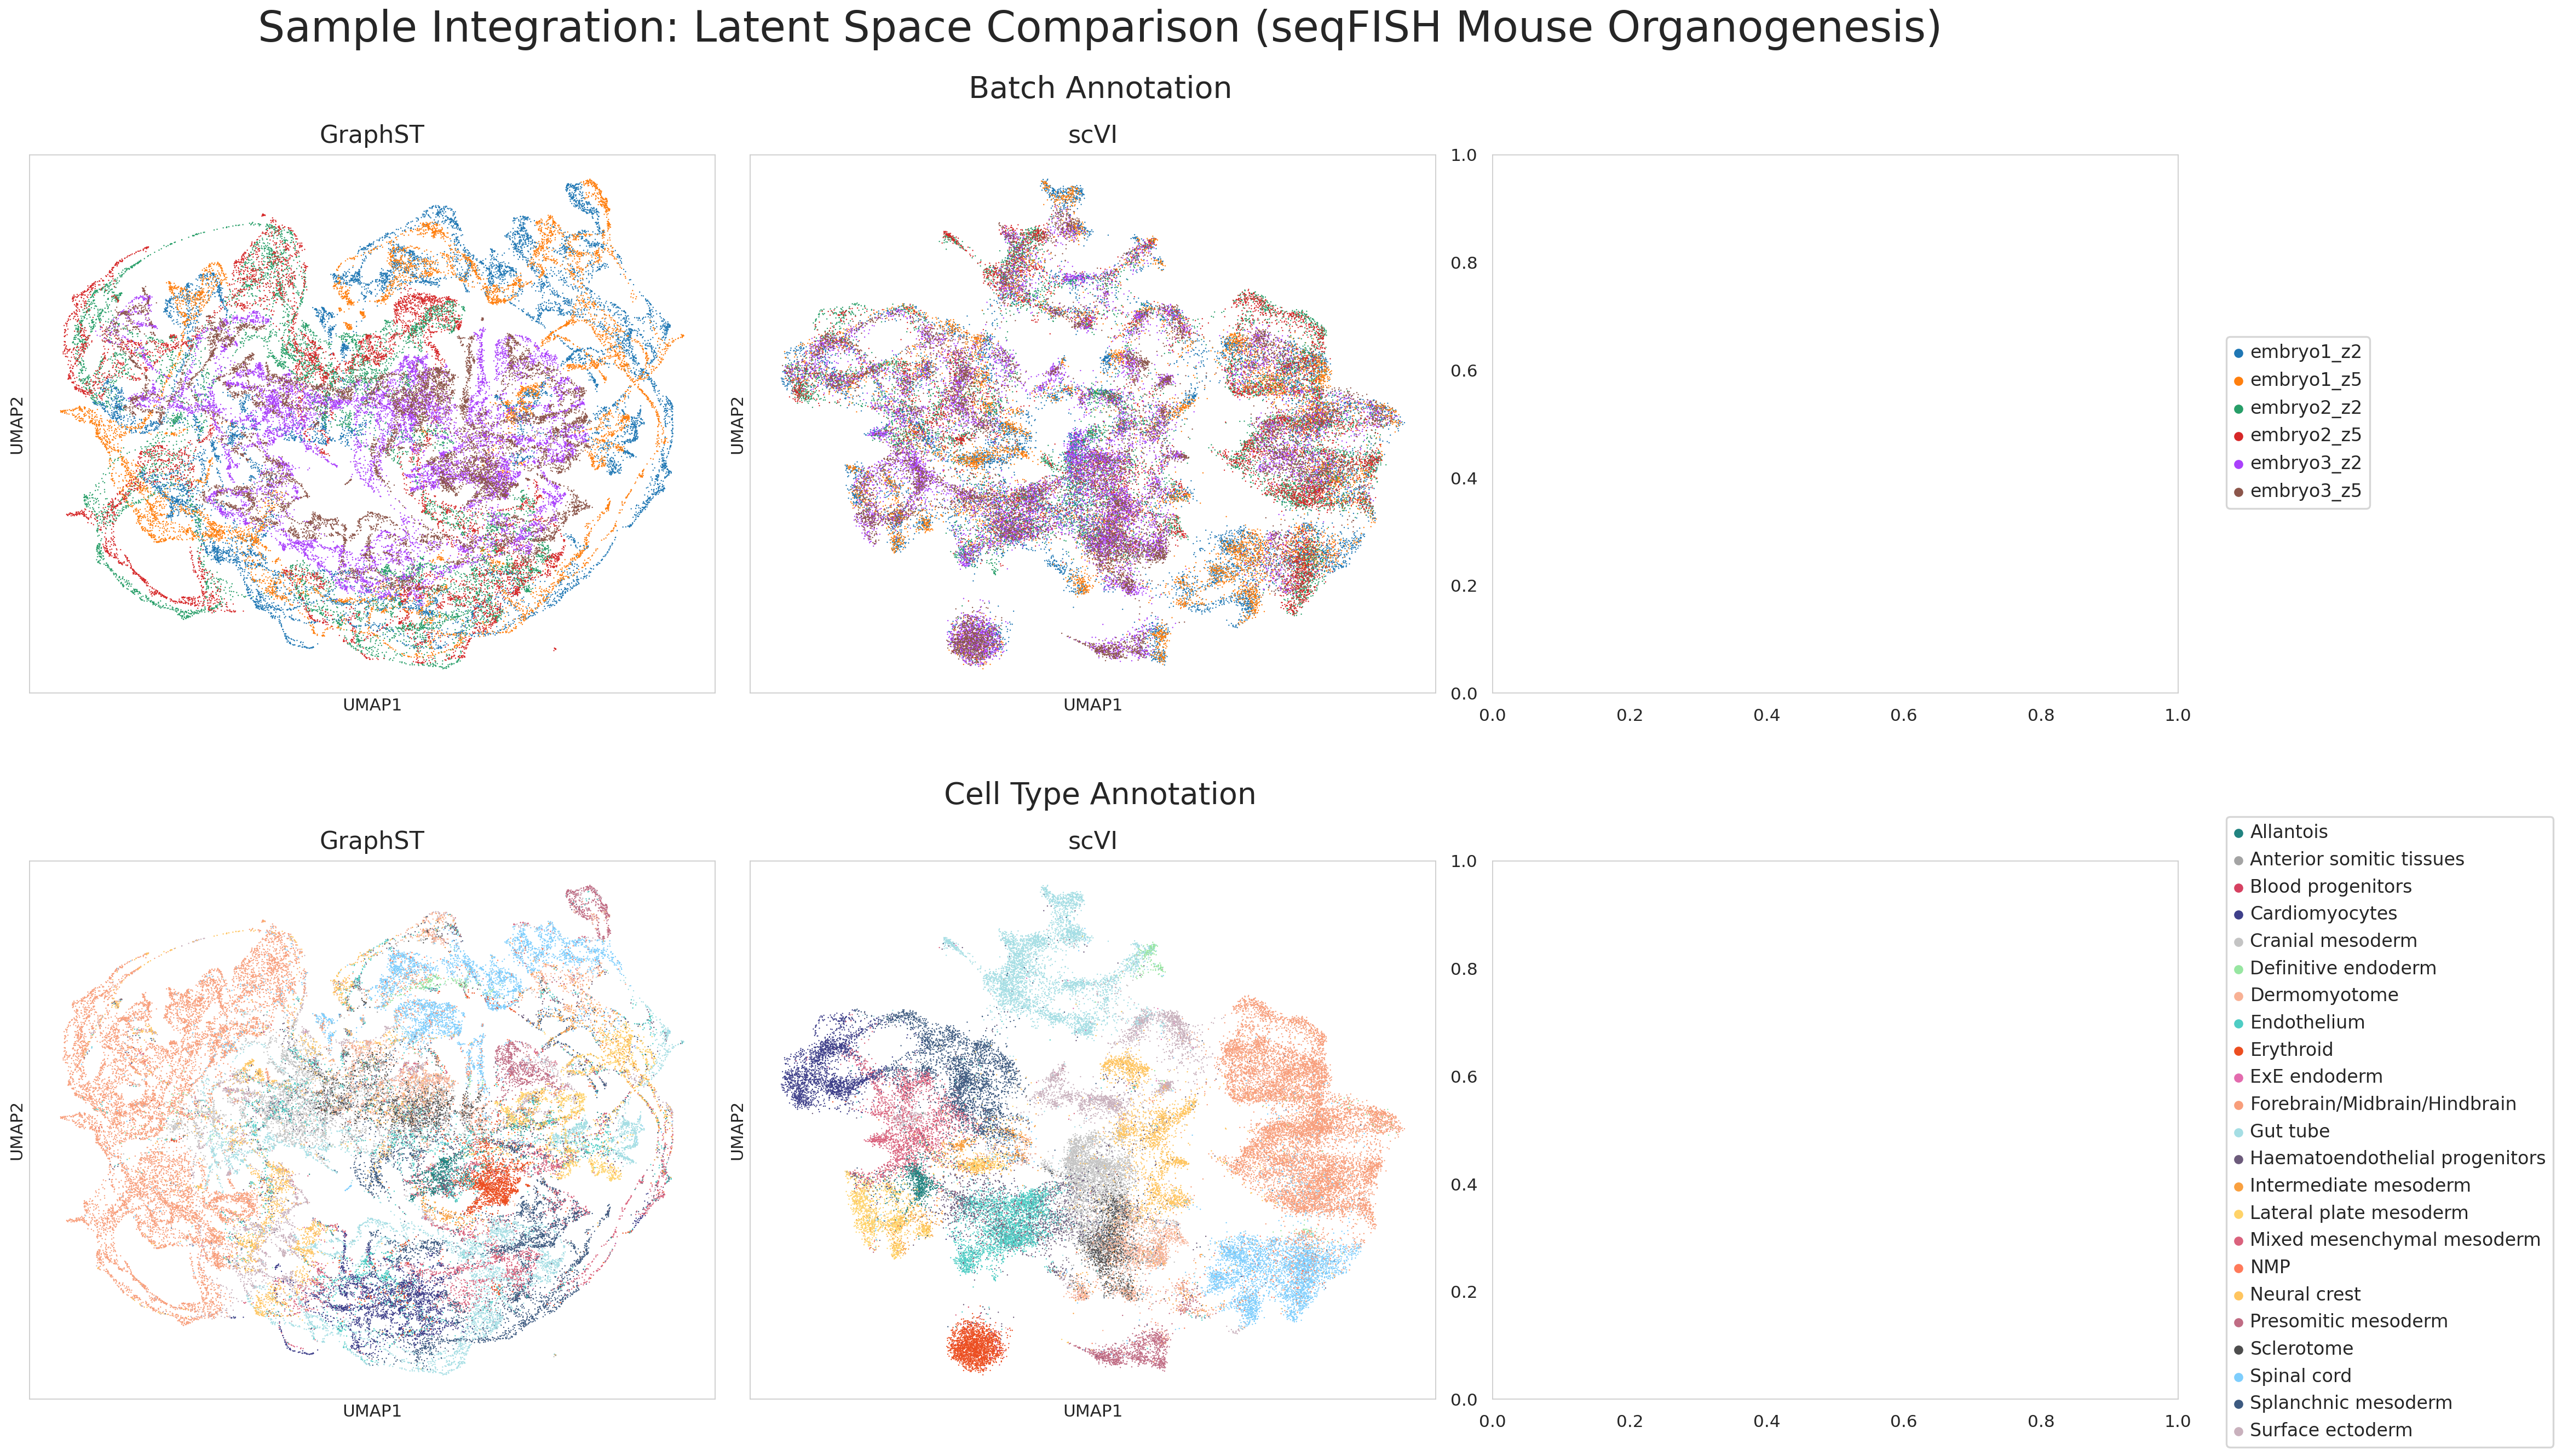

In [36]:
run_number = 5

compute_latent_space_comparison(dataset="seqfish_mouse_organogenesis",
                                run_number=run_number,
                                srt_data_results_folder_path=f"{srt_data_results_folder_path}/sample_integration_method_benchmarking",
                                cell_type_colors=seqfish_mouse_organogenesis_cell_type_colors,
                                dataset_title_string="seqFISH Mouse Organogenesis",
                                cell_type_key="cell_type",
                                condition_key="batch",
                                figure_folder_path=figure_folder_path,
                                cell_type_groups=None,
                                spot_size=0.03,
                                included_models=[# "NicheCompass",
                                                 "GraphST",
                                                 "scVI"],
                                save_fig=True)

In [ ]:
run_number = 5

compute_latent_space_comparison(dataset="starmap_plus_mouse_cns",
                                run_number=run_number,
                                srt_data_results_folder_path=f"{srt_data_results_folder_path}/sample_integration_method_benchmarking",
                                cell_type_colors=seqfish_mouse_organogenesis_cell_type_colors,
                                dataset_title_string="seqFISH Mouse Organogenesis",
                                cell_type_key="cell_type",
                                condition_key="batch",
                                figure_folder_path=figure_folder_path,
                                cell_type_groups=None,
                                spot_size=0.03,
                                included_models=[# "NicheCompass",
                                                 "GraphST",
                                                 "scVI"],
                                save_fig=True)

##### 4.1.3.3 Compute Batch Integration Metrics

In [ ]:
adata = sc.read_h5ad("../../datasets/srt_data/results/sample_integration_method_benchmarking/seqfish_mouse_organogenesis_graphst_sample_integration_method_benchmarking.h5ad")

In [ ]:
adata

In [ ]:
compute_batch_integration_metrics(dataset="seqfish_mouse_organogenesis",
                                  condition_key="batch",
                                  cell_type_key="cell_type",
                                  srt_data_results_folder_path=srt_data_results_folder_path,
                                  metric_artifacts_folder_path=metric_artifacts_folder_path,
                                  included_models=[#"NicheCompass",
                                                   "GraphST",
                                                   "scVI"])

##### 4.1.3.4 Visualize Batch Integration Results

In [ ]:
df = pd.DataFrame()
datasets = ["starmap_plus_mouse_cns",]
timestamps = ["27032023_184359"]

for dataset, timestamp in zip(datasets, timestamps):
    dataset_metric_artifacts_folder_path = f"../artifacts/{dataset}/metrics/{timestamp}"
    
    metrics_dict_list = []
    for model in ["NicheCompass", "GraphST", "scVI"]:
        # Read complete benchmarking data from disk
        with open(f"{dataset_metric_artifacts_folder_path}/metrics_{model.lower()}_oneshot_integrated.pickle", "rb") as f:
            metrics_dict = pickle.load(f)
            metrics_dict["model_name"] = model.lower()
            metrics_dict_list.append(metrics_dict)
    
    dataset_df = pd.DataFrame(metrics_dict_list)
    dataset_df["dataset"] = dataset

df = pd.concat([df, dataset_df])
df.head()

columns = ["cas",
           "clisis",
           "asw",
           "ilisi",
           ]

rows = ["nichecompass",
        "graphst",
        "scvi"]

unrolled_df = pd.melt(df, 
   id_vars = ["model_name", "dataset"],
   value_vars = columns,
   var_name = "score_type", 
   value_name = "score")

# Compute metric means over all runs
mean_df = unrolled_df.groupby(["model_name", "dataset", "score_type"]).mean()
mean_df.reset_index(inplace=True)

# Reformat for plot
mean_df.replace({"nichecompass": "NicheCompass",
                 "graphst": "GraphST",
                 "scvi": "scVI"}, inplace=True)

# Sort for right order of columns in plottable
mean_df["score_type"] = pd.Categorical(mean_df["score_type"], ["cas", "clisis", "asw", "ilisi"])
mean_df.sort_values(["model_name", "score_type"], inplace=True)

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model_name"] in ["NicheCompass", "GraphST"]:
        return True
    return False
mean_df["spatially_aware"] = mean_df.apply(lambda row: is_spatially_aware_model(row), axis=1)

In [ ]:
plot_batch_integration_results(mean_df,
                               show=True,
                               save_dir=None,
                               save_name="batch_integration_results.svg")

##### 4.1.3.4 Scalability

In [ ]:
datasets = ["seqfish_mouse_organogenesis", "starmap_plus_mouse_cns"]
models = ["NicheCompass (Attention Aggregator)", "NicheCompass (Norm Aggregator)", "GraphST", "scVI"]

run_time_dict = {"Dataset": [],
                 "Model": [],
                 "Dataset Size (%)": [],
                 "Mean Runtime (s)": []}

for dataset in datasets:
    for model in models:
        for subsample_pct in [1, 5, 10, 25, 50, 100]:
            if model == "NicheCompass (Attention Aggregator)":
                model_subtype = "nichecompass_one-hop-attention"
                model_str = "nichecompass"
            elif model == "NicheCompass (Norm Aggregator)":
                model_subtype = "nichecompass_one-hop-norm"
                model_str = "nichecompass"
            else:
                model_subtype = model
                model_str = model
                
            if subsample_pct == 100:
                subsample_str = ""
            else:
                subsample_str = f"_subsample_{subsample_pct}pct"

            try:
                adata = sc.read_h5ad(f"{srt_data_results_folder_path}/{dataset}{subsample_str}_{model_subtype.lower()}_sample_integration_method_benchmarking.h5ad")
            except:
                print(f"Did not load {dataset}{subsample_str}_{model_subtype.lower()}_sample_integration_method_benchmarking.h5ad")
                continue
                
            print(f"Loaded {dataset}{subsample_str}_{model_subtype.lower()}_sample_integration_method_benchmarking.h5ad")

            run_times = []
            for run_number in range(1, 11):
                run_times.append(adata.uns[f"{model_str.lower()}_model_training_duration_run{run_number}"])
            run_time_dict["Dataset"].append(dataset)
            run_time_dict["Model"].append(model)
            run_time_dict["Dataset Size (%)"].append(subsample_pct)
            run_time_dict["Mean Runtime (s)"].append(np.mean(run_times))

run_time_df = pd.DataFrame(run_time_dict)
display(run_time_df)

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot the first lineplot in the first subplot
sns.lineplot(x="Dataset Size (%)", y="Mean Runtime (s)", hue=run_time_df["Model"], data=run_time_df[run_time_df["Dataset"] == "seqfish_mouse_organogenesis"], marker="o", ax=axs[0])
axs[0].set_title("seqFISH Mouse Organogenesis")

# Plot the second lineplot in the second subplot
sns.lineplot(x="Dataset Size (%)", y="Mean Runtime (s)", hue=run_time_df["Model"], data=run_time_df[run_time_df["Dataset"] == "starmap_plus_mouse_cns"], marker="o", ax=axs[1], legend=False)
axs[1].set_title("STARmap PLUS Mouse CNS")

# Remove the legend title
leg = axs[0].legend()
leg.set_title("")

# Add a grid to both subplots
for ax in axs:
    ax.grid(True, linewidth=0.2, color='lightgrey')
    
plt.subplots_adjust(wspace=0.05)

plt.savefig(f"{figure_folder_path}/method_comparison_scalability.svg",
            bbox_inches="tight")
plt.show()

### 4.2 Query-to-Reference Mapping

#### 3.3.1 Building the Reference

#### 3.3.2 Mapping the Query

##### 3.3.2.1 Initialize, Train & Save Model

In [11]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference,
                 color=[cell_type_key],
                 palette=starmap_pluse_mouse_cns_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

NameError: name 'adata_reference' is not defined

##### 4.1.1.2 GraphST

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference,
                 color=[cell_type_key],
                 palette=starmap_pluse_mouse_cns_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

#### 4.1.2 NicheCompass

In [ ]:
model_name = "NicheCompass"

# Load trained model
model = NicheCompass.load(dir_path=model_artifacts_folder_path + "/reference",
                        adata=None,
                        adata_file_name=f"{dataset}_reference.h5ad",
                        gp_names_key="nichecompass_gp_names")

adata_reference = model.adata

# Use NicheCompass latent representation for UMAP generation
sc.pp.neighbors(adata_reference,
                use_rep=f"{model_name.lower()}_{latent_key}")
sc.tl.umap(adata_reference)

# Save integrated adata to disk
adata_reference.write(f"{srt_data_gold_folder_path}/{dataset}_{model_name.lower()}_oneshot_integrated.h5ad")

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
plt.title(f"One-Shot Integration: {model_name} Latent Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference,
                 color=[cell_type_key],
                 palette=starmap_pluse_mouse_cns_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
plt.title(f"One-Shot Integration: {model_name} Latent Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")